<a href="https://colab.research.google.com/github/sdhar2020/WebsiteCode/blob/main/4_RFMSegmentation_Generic_Online.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and Libraries

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from scipy import stats
SEED=4242
rnd.seed(10)
SIZE=30000
ALPHA=0.03

In [330]:
df0= pd.read_csv('https://raw.githubusercontent.com/ugursavci/Customer_Segmentation_using_RFM_Analysis/main/Online_Retail.csv', low_memory=False)

In [331]:
df0.shape

(495478, 8)

In [332]:
df0['InvoiceDate'] = pd.to_datetime(df0['InvoiceDate'])
df0 = df0[(df0.Quantity>0) & (df0.UnitPrice> 0)]
df0 = df0[~df0['StockCode'].str.contains('C')]
df0 = df0.drop_duplicates()
df0.dropna(inplace=True)
df0['Total_Price'] = df0['UnitPrice']*df0['Quantity']
now= df0.InvoiceDate.max()
df0.shape

(345460, 9)

In [333]:
df = df0.groupby('CustomerID').agg({'InvoiceDate' : lambda day : (now - day.max()).days,
                               'InvoiceNo': lambda num : len(num),
                              'Total_Price': lambda price : price.sum()
                             
                             
                             })
col_list = ['Recency','Frequency','Monetary']
df.columns = col_list

In [334]:
df['Recency']= df.Recency+1

## Variables

In [335]:
df.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [336]:
df.describe()

,Recency,Frequency,Monetary
count,3915.000000,3915.000000,3915.000000
mean,92.147382,88.240102,1841.609007
std,99.502531,211.659948,7397.862533
min,1.000000,1.000000,3.750000
25%,18.000000,16.000000,293.275000
50%,51.000000,40.000000,640.410000
75%,142.500000,97.000000,1558.560000
max,374.000000,7604.000000,254101.760000


In [337]:
df.shape

(3915, 3)

In [338]:
for c in ['Recency', 'Frequency', 'Monetary']:
  v= df.loc[:,c].describe(percentiles=[.05,.95]).loc[['5%', '95%']].values
  df=df[df.loc[:,c].between(v[0], v[1])]

In [339]:
df.shape

(2892, 3)

# K Means Modeling

## Scaling

In [340]:
qseries= np.zeros(len(df))
for c in df.columns:
  qseries= qseries+ pd.qcut(df[c], 5, labels=False, duplicates= 'drop').values+1
  print(c)
# df1['qsum']= qseries

Recency
Frequency
Monetary


In [341]:
# plt.hist(qseries, bins= 20) 

In [342]:
mms = MinMaxScaler()
mms.fit(df)
data_transformed = mms.transform(df)

In [343]:
idx= [i for i,v in enumerate(data_transformed[0:].tolist())]

In [344]:
qseries

array([ 9., 10., 10., ...,  7.,  3., 12.])

## Train/ Test 

In [345]:
train, test, idx_train, idx_test = train_test_split(data_transformed, idx, test_size=0.005, shuffle= True, random_state=4242, stratify= qseries)

## Choice of clusters

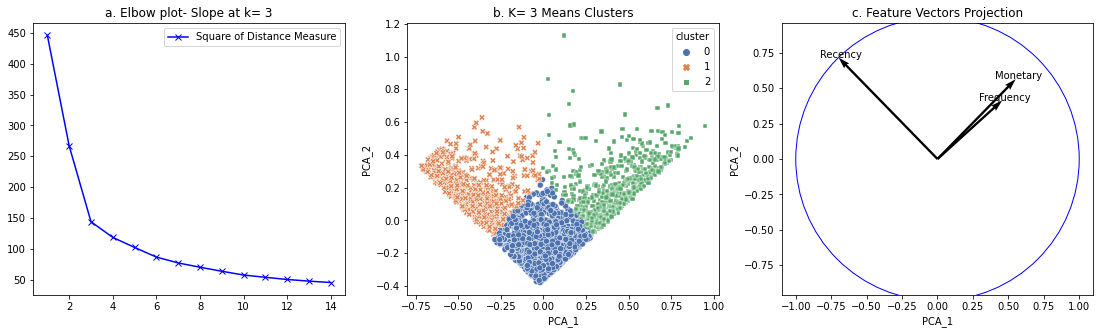

In [378]:
my_dpi= 300
fig, ax = plt.subplots(1, 3,figsize=(5700/my_dpi,1500/my_dpi), sharey= False, )
Sum_of_squared_distances = []
# plt.figure(figsize=(12,10))
K = range(1,15)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(train)
 Sum_of_squared_distances.append(kmeans.inertia_)
ax[0].plot(K,Sum_of_squared_distances,'bx-', label= 'Square of Distance Measure')
# plt.xlabel('Values of K') 
# plt.ylabel('Sum of squared distances/Inertia') 
ax[0].legend()
ax[0].set_title('a. Elbow plot- Slope at k= 3')
# plt.title('Elbow Method For Optimal k’')
km = KMeans(n_clusters=3, random_state=4242)
km = km.fit(train)
tr_cluster_labels = km.labels_
pca = PCA(n_components=2)
pca.fit(train)
df3= pd.DataFrame(pca.fit_transform(train))
df3.columns= ['PCA_1', 'PCA_2']
df3['cluster']= tr_cluster_labels
sns.scatterplot(data=df3, x="PCA_1", y="PCA_2", hue="cluster", style= 'cluster', palette="deep", ax=ax[1])
ax[1].set_title("b. K= 3 Means Clusters")
PCs = pca.components_

# Use quiver to generate the basic plot
# fig = plt.figure(figsize=(12,12))
ax[2].quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = df.columns
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')

plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
ax[2].axis('equal')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

# Label axes
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
ax[2].set_title('c. Feature Vectors Projection')
# plt.show()
plt.savefig('2.cluster.svg', bbox_inches='tight',fontsize = 20)

In [347]:
# lminIdx

# Result & Insights

## Variable Analysis

In [348]:
df.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [349]:
df['cluster']= -9999
df['flag']= 'NA'

In [350]:
df.iloc[idx_train,3]= tr_cluster_labels
df.iloc[idx_train,4]= 'train'

In [351]:
df.iloc[idx_test,3]= -999
df.iloc[idx_test,4]= 'test'

In [352]:
pd.crosstab(df.flag, df.cluster, normalize='index')

cluster,-999,0,1,2
flag,,,,
test,1.0,0.000000,0.000000,0.000000
train,0.0,0.554049,0.226625,0.219326


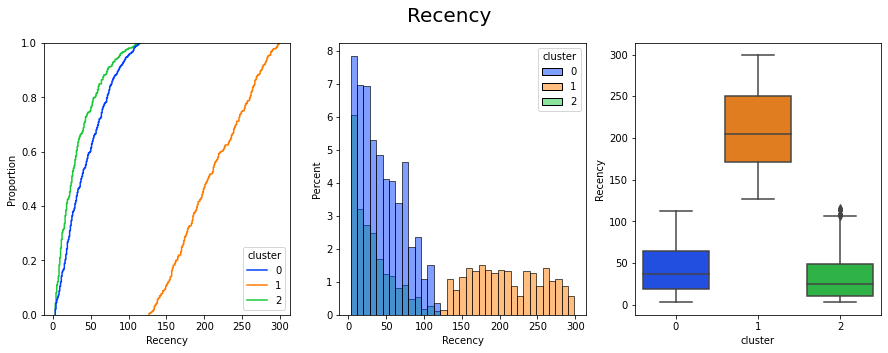

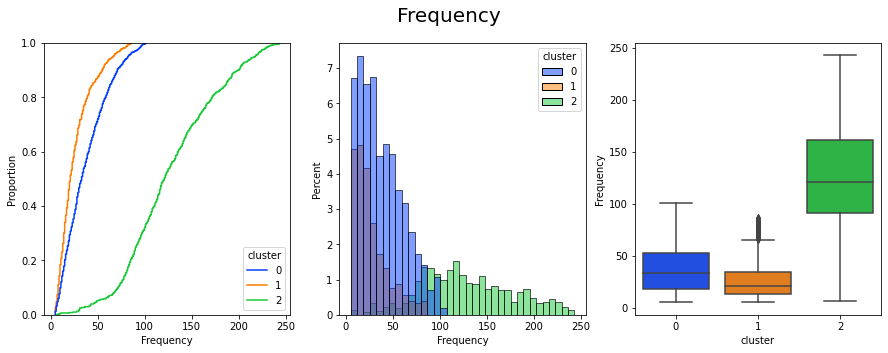

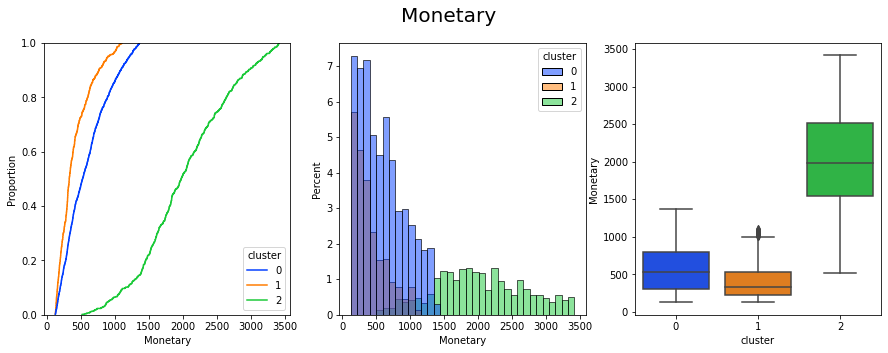

In [353]:
for c in ['Recency', 'Frequency', 'Monetary']:
  gf1= df.loc[df.flag=='train']
  gf2=gf1.groupby('cluster')[c].quantile(.95).reset_index()
  gf1= gf1.merge(gf2, how='inner', on= 'cluster', suffixes=('', '_y'))
  gf1=gf1.loc[gf1.loc[:,c] <= gf1.loc[:,c+'_y']]
  fig, axes = plt.subplots(1,3,figsize=(4500/my_dpi,1500/my_dpi), sharey= False)
  # fig, ax = plt.subplots(figsize=(4000/my_dpi,1500/my_dpi)) 
  # gf2= df1.loc[df1.flag=='test']
  fig.suptitle(c, fontsize=20)
  sns.ecdfplot(gf1, x= c, ax=axes[0], hue= 'cluster', palette='bright')
  # sns.ecdfplot(gf2, x= c, ax=axes[1,0], hue= 'cluster', palette='bright')
  sns.histplot(gf1, x= c, ax=axes[1], hue= 'cluster', palette='bright', stat= 'percent', bins=35)
  # sns.histplot(gf2, x= c, ax=axes[1,1], hue= 'cluster', palette='bright')
  sns.boxplot(data=gf1, x= 'cluster', y=c, palette='bright')
  # sns.boxplot(gf2, x= c, ax=axes[1,1], hue= 'cluster', palette='bright')
  # fig.tight_layout()
  # fig.subplots_adjust(top=0.90)
  # plt.show()
  plt.savefig('3.'+c+'.svg', bbox_inches='tight',fontsize = 20)
  # plt.close()

In [354]:
df.head()

,Recency,Frequency,Monetary,cluster,flag
CustomerID,,,,,
12820.0,3,59,942.34,0,train
12822.0,71,46,948.88,0,train
12823.0,75,5,1759.50,0,train
12824.0,60,25,397.12,0,train
12826.0,3,91,1474.72,2,train


## RFM Scoring

In [355]:
df= df.loc[df.flag== 'train']

In [356]:
df.describe()

,Recency,Frequency,Monetary,cluster
count,2877.000000,2877.000000,2877.000000,2877.000000
mean,83.309002,59.464025,916.745615,0.665276
std,81.199145,54.118263,790.971610,0.813366
min,3.000000,5.000000,126.290000,0.000000
25%,22.000000,20.000000,327.840000,0.000000
50%,52.000000,41.000000,641.250000,0.000000
75%,122.000000,82.000000,1258.060000,1.000000
max,311.000000,288.000000,3704.250000,2.000000


In [357]:
# df['Recency']= df[['nDebitRecency','nCreditRecency']].min(axis=1)
# df['Frequency']= df[['nDebitFrequency', 'nCreditFrequency' ]].max(axis=1)
# df['MonetaryValue']= df[['nDebitValue','nCreditValue']].max(axis=1)

In [358]:
# df.describe()

In [359]:
df['R_Score']= pd.qcut(df.Recency,5, labels=[5,4,3,2,1]).astype(float)
df['F_Score']= pd.qcut(df.Frequency,5, labels=[1,2,3,4,5]).astype(float)
df['M_Score']= pd.qcut(df.Monetary,5,labels= [1,2,3,4,5]).astype(float)
df['RFM']=df.R_Score+df.F_Score+ df.M_Score
df['RFM_Score']= pd.qcut(df.RFM,5,labels= [1,2,3,4,5]).astype(float)
# Most Valuable Consumers
df['MVC']= df.RFM>= 13
# Segments
df['RFM_labels']= list(zip(np.where (df.R_Score >= 4, '1.Recent', '2.Not Recent'), np.where (df.F_Score >= 4, 'Frequent', 'Infrequent'), np.where (df.M_Score >= 4, 'Hi Value', 'Not Hi Value')))
df['RFM_labels']= df.RFM_labels.agg('|'.join)

In [360]:
pd.crosstab(df.RFM_Score, df.MVC)

MVC,False,True
RFM_Score,,
1.0,787,0
2.0,534,0
3.0,514,0
4.0,485,0
5.0,0,557


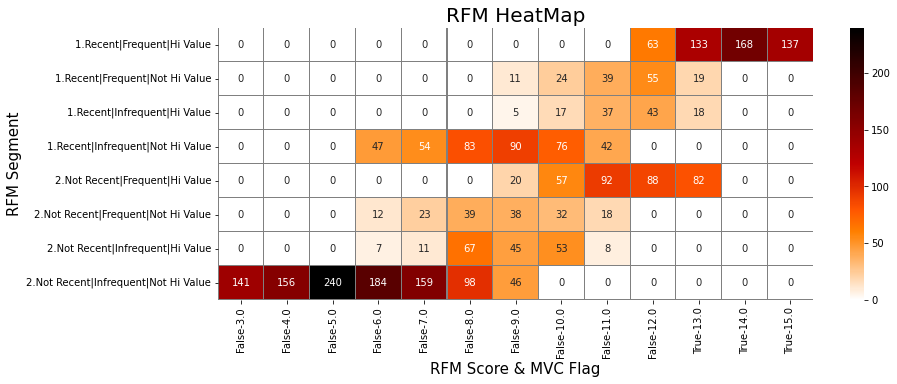

In [361]:
my_dpi= 300

fig, ax = plt.subplots(figsize=(4000/my_dpi,1500/my_dpi)) 
sns.heatmap(pd.crosstab(df.RFM_labels, [df.MVC,df.RFM]), cmap='gist_heat_r', ax=ax, annot= True, fmt='d',linewidths=.05, linecolor='gray')
plt.xlabel('RFM Score & MVC Flag', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('RFM Segment', fontsize = 15)
plt.title('RFM HeatMap', fontsize = 20, )
# plt.savefig('RFM.png', dpi=my_dpi,orientation='landscape')
plt.savefig('1.RFM.svg', bbox_inches='tight',fontsize = 20)

In [362]:
plt.close()

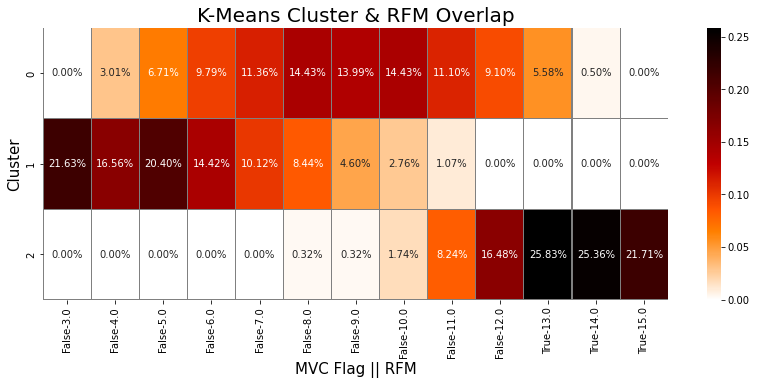

In [363]:
my_dpi= 300

fig, ax = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi)) 
gf= pd.crosstab([df.MVC,df.RFM], df.cluster).apply(lambda r: r/r.sum(), axis=0).T
sns.heatmap(gf, cmap='gist_heat_r', ax=ax, annot= True, fmt='.2%',linewidths=.05, linecolor='gray')
plt.ylabel('Cluster', fontsize = 15) # x-axis label with fontsize 15
plt.xlabel('MVC Flag || RFM', fontsize = 15)
plt.title('K-Means Cluster & RFM Overlap', fontsize = 20, )
plt.savefig('4.KMC_RFM.svg', bbox_inches='tight',fontsize = 20)

## Profiling

In [364]:
df['target']= np.where(df.cluster==2, 1, 0)

In [365]:
Gender=['Female', 'Male', 'Unknown']
YoungChildren=[True, False]
Age= ['<=18', '>18-35', '>35-50', '>50-60', '>60']
Income= ['<=25K-50K', '>50K-70<K', '>70K-100K', '>100K']
OnlineShopping3M= [True, False]

In [366]:
np.random.seed(4242)
df.loc[df.target==1, 'Gender']= np.random.choice(Gender, size=sum(df.target==1), p=[.7,.2,.1])
df.loc[df.target!=1, 'Gender']= np.random.choice(Gender, size=sum(df.target!=1), p=[.35,.35,.3])
df.loc[df.target==1, 'YoungFamily']= np.random.choice(YoungChildren, size=sum(df.target==1), p=[.9,.1])
df.loc[df.target!=1, 'YoungFamily']= np.random.choice(YoungChildren, size=sum(df.target!=1), p=[.5,.5])
df.loc[df.target==1, 'Age']= np.random.choice(Age, size=sum(df.target==1), p=[.15,.4,.3,.1,.05])
df.loc[df.target!=1, 'Age']= np.random.choice(Age, size=sum(df.target!=1), p=[.3,.1,.15,.3,.15])
df.loc[df.target==1, 'Income']= np.random.choice(Income, size=sum(df.target==1), p=[.1,.1,.5,.3])
df.loc[df.target!=1, 'Income']= np.random.choice(Income, size=sum(df.target!=1), p=[.4,.3,.25,.05])
df.loc[df.target==1, 'OnlineShopping3M']= np.random.choice(OnlineShopping3M, size=sum(df.target==1), p=[.8,.2])
df.loc[df.target!=1, 'OnlineShopping3M']= np.random.choice(OnlineShopping3M, size=sum(df.target!=1), p=[.4,.6])

In [367]:
# pd.crosstab(df.target.map({0:' Non MVC', 1: 'MVC'}), df.loc[:,c], normalize='columns').T.plot(kind='bar', stacked=True, color=['red', 'blue'])

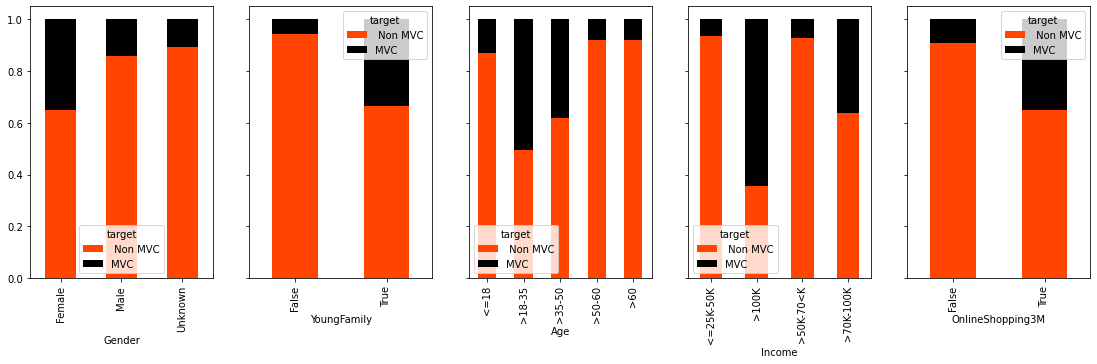

In [368]:
my_dpi= 300

fig, ax = plt.subplots(1, 5,figsize=(5700/my_dpi,1500/my_dpi), sharey= True, ) 
for i,c in enumerate(['Gender', 'YoungFamily', 'Age', 'Income', 'OnlineShopping3M']):
  pd.crosstab(df.target.map({0:' Non MVC', 1: 'MVC'}), df.loc[:,c], normalize='columns').T.plot(ax= ax[i], kind='bar', stacked=True, color=['orangered', 'black'])
  # plt.xlabel(c)
  plt.ylabel('%')
  # plt.title('Relative Proportions of Occurence of MVC', loc='center')
  plt.savefig('5.bar.svg', bbox_inches='tight',fontsize = 20)

In [369]:
gf

MVC         False                                                              \
RFM          3.0       4.0       5.0       6.0       7.0       8.0       9.0    
cluster                                                                         
0        0.000000  0.030113  0.067127  0.097867  0.113551  0.144291  0.139900   
1        0.216258  0.165644  0.203988  0.144172  0.101227  0.084356  0.046012   
2        0.000000  0.000000  0.000000  0.000000  0.000000  0.003170  0.003170   

MVC                                        True                      
RFM          10.0      11.0      12.0      13.0      14.0      15.0  
cluster                                                              
0        0.144291  0.111041  0.090966  0.055834  0.005019  0.000000  
1        0.027607  0.010736  0.000000  0.000000  0.000000  0.000000  
2        0.017433  0.082409  0.164818  0.258320  0.253566  0.217116

In [370]:
X=pd.get_dummies(df[['Gender', 'YoungFamily', 'Age', 'Income', 'OnlineShopping3M']], drop_first=True).values
y= df.target.values

In [371]:
feat= pd.get_dummies(df[['Gender', 'YoungFamily', 'Age', 'Income', 'OnlineShopping3M']], drop_first=True).columns

In [372]:
feat

Index(['Gender_Male', 'Gender_Unknown', 'YoungFamily_True', 'Age_>18-35',
       'Age_>35-50', 'Age_>50-60', 'Age_>60', 'Income_>100K',
       'Income_>50K-70<K', 'Income_>70K-100K', 'OnlineShopping3M_True'],
      dtype='object')

In [373]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [374]:
clf = DecisionTreeClassifier(min_samples_leaf=50, criterion='entropy', random_state=4242, max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=50,
                       random_state=4242)

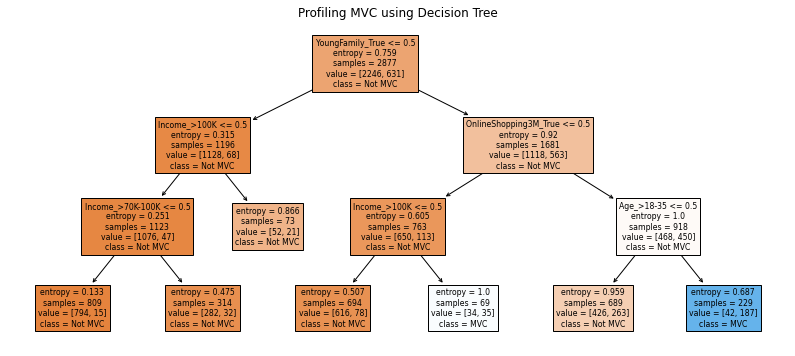

In [375]:
my_dpi= 300

fig, ax = plt.subplots(figsize=(4200/my_dpi,1800/my_dpi)) 
tree.plot_tree(clf, filled= True, ax=ax, feature_names=feat, class_names=['Not MVC', 'MVC'], label='all')
plt.title('Profiling MVC using Decision Tree')
plt.savefig('6.tree.svg', bbox_inches='tight',fontsize = 20)

In [376]:
from sklearn.tree import export_text
tree_rules = export_text(clf, feature_names=list(feat))

In [377]:
print(tree_rules)

|--- YoungFamily_True <= 0.50
|   |--- Income_>100K <= 0.50
|   |   |--- Income_>70K-100K <= 0.50
|   |   |   |--- class: 0
|   |   |--- Income_>70K-100K >  0.50
|   |   |   |--- class: 0
|   |--- Income_>100K >  0.50
|   |   |--- class: 0
|--- YoungFamily_True >  0.50
|   |--- OnlineShopping3M_True <= 0.50
|   |   |--- Income_>100K <= 0.50
|   |   |   |--- class: 0
|   |   |--- Income_>100K >  0.50
|   |   |   |--- class: 1
|   |--- OnlineShopping3M_True >  0.50
|   |   |--- Age_>18-35 <= 0.50
|   |   |   |--- class: 0
|   |   |--- Age_>18-35 >  0.50
|   |   |   |--- class: 1

